**Important! Please do not remove any cells, including the test cells, even if they appear empty. They contain hidden tests, and deleting them could result in a loss of points, as the exercises are graded automatically. Only edit the cells where you are instructed to write your solution.**  

### Exercise 6: Generative Adversarial Network
In this exercise, you will train a generative adversarial network (GAN) for **generaring images from random noise**

GAN involves two neural network model: **generator** to generate fake images from noisy signal and **discriminator** to discriminate between the real and fake images.

The dataset used in this exercise is the [MNIST](https://yann.lecun.com/exdb/mnist/), which contains of 60000 training images of handwritten digits, from 0 to 9 in grey scale color.

#### Code template
To complete this assignment, you will fill in the provided code template below. Your main tasks include:

1. **Defining the Model (6 points)**
2. **Setting the Loss Criterion and Optimizer (2 points)**
3. **Writing the Training Loop (12 points)**

Make sure to follow the instructions in the code template carefully and test your implementation before submission. If your code passes all the visible test cases, you get 50% of the points for each task. The remaining points are based on hidden test cases evaluated after submission.

**Deliverables:** <br>

Submit the completed notebook (ex6.ipynb) and your trained models (best_generator.pth and best_discriminator.pth) to moodle.
Do not change the name of the notebook file. It may result in 0 points for the exercise.

**Let's begin!**

In [1]:
skip_training = False   # You can set it to True if you want to run inference on your trained model.

# Set the parameters
# Do not change the noise size
max_epochs = 20
noise_size = 100
batch_size = 32

In [2]:
# Do not delete this cell

<h3>Import all the necessary libraries </h3>

Firstl, we will import the essential libraries needed for building and training a deep learning model using PyTorch.

In [3]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms


<h3> Select the device the run the model.</h3>

In this step, we will determine whether the model will run on a GPU (if available) or fall back to the CPU. Using a GPU for deep learning tasks can significantly speed up training, especially with large models or datasets.

- `torch.device('cuda' if torch.cuda.is_available() else 'cpu')`: This checks for a CUDA-enabled GPU.
  - If a GPU is available, it assigns `'cuda'` as the device.
  - If no GPU is available, it defaults to the CPU (`'cpu'`).

Make sure to always transfer both the model and the data to the selected dvice.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<h3> Download the dataset and create a dataloader to loop through mini batches of data. </h3>

In this step, we will download and prepare the MNIST dataset, which consists of 28x28 pixel images of handwritten digits. We will split the dataset into a training set and a test set.

- `MNIST`: Downloads the dataset and applies the transformation to
  - resize the image to 32x32 pixel image
  - transform the image to Tensor
  - normalize the pixel values to [-1,1]
- `train_size` and `test_size`: Specify the number of samples for the training and testing datasets, respectively. Here, we're using 4000 samples for training and 1000 for testing.
- `random_split`: Randomly splits the dataset into the specified sizes for training and testing.
- `DataLoader`: Loads the dataset into batches, making it easier to iterate through the dataset during training and testing.
  - `batch_size=32`: Each batch will contain 32 images.
  - `shuffle=True/False`: Randomly shuffles the dataset at each epoch to improve training.

In [5]:
dataset_path = './dataset_ex6' # you can change the path if you want to store the dataset somewhere else.

In [6]:
# Do not delete this cell

#### **2 - Dataset**

##### Creating Pytorch Dataset and Dataloader

In [7]:
#MNIST dataset
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])
dataset = MNIST(root=dataset_path,
                train=True,
                transform=transform,
                download=True,)

train_size = 0.8
test_size = 0.2
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.44MB/s]


Extracting ./dataset_ex6/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset_ex6/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./dataset_ex6/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset_ex6/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./dataset_ex6/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset_ex6/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.89MB/s]

Extracting ./dataset_ex6/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset_ex6/MNIST/raw



<h3>Visualizing data</h3>

The following code block visualizes the some of the images from the dataset.

Batch shape: torch.Size([32, 1, 32, 32])


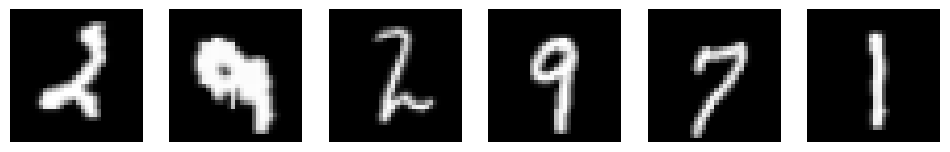

In [8]:
batch, _ = next(iter(train_loader))
displayed_images = batch[:6].squeeze(1)
fig, ax = plt.subplots(1, 6, figsize=(12, 4))

for i in range(6):
    ax[i].imshow(displayed_images[i], cmap='gray')
    ax[i].axis('off')

print(f"Batch shape: {batch.shape}")

<h3>Task 1: Define the Model classes <b> (6 points) </b>. </h3>

<h4>Task 1.1: Define the Discriminator class <b> (3 points) </b></h4>
Your task is implementing a discriminator according to the architecture shown below. The dicriminator takes the image as the model input and output the predicting probability of the image being real image.

**Your Task:**
- Initialize all the layers in the `__init__` method.
- Complete the `forward` method to pass the input through the layers in accordance with the architecture.
- The order of the layers within a block is : Conv2D -> BatchNorm -> Activation layer

<div style="text-align: center;">
    <img src="disc.png" style="width:800px; height:auto;"/>
</div>

In [9]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # YOUR CODE HERE
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0),
            nn.Sigmoid()
        )

    def forward(self,
                x:torch.Tensor) -> torch.Tensor:

        # YOUR CODE HERE
        out_conv1 = self.conv1(x)
        out_conv2 = self.conv2(out_conv1)
        out_conv3 = self.conv3(out_conv2)
        out_conv4 = self.conv4(out_conv3)
        squeezed = out_conv4.squeeze(-1, -2)

        return squeezed

**Test the correctness of your model by running the cell below**

In [10]:
# test the model definition
all_tests_successful = True
conv2d_count, bn2d_count = 0, 0

test_discriminator = Discriminator()
for layer in test_discriminator.modules():
    if isinstance(layer, nn.Conv2d):
        conv2d_count += 1
    if isinstance(layer, nn.BatchNorm2d):
        bn2d_count += 1

dummy_input = torch.randn(4,1,32,32)
dummy_output = test_discriminator(dummy_input)

if dummy_output.shape != (4,1):
    all_tests_successful = False
    raise AssertionError(f"Expected output shape (4,1), instead got {dummy_output.shape}.")

if conv2d_count != 4:
    all_tests_successful = False
    raise AssertionError(f"Expected 4 Conv2d layers, got {conv2d_count}.")

if bn2d_count != 3:
    all_tests_successful = False
    raise AssertionError(f"Expected 3 BatchNorm2d layers, got {bn2d_count}.")

if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed! You can proceed further.


In [11]:
# This cell contains hidden test cases that will be evaluated after submission

<h4>Task 1.2: Define the Generator class <b> (3 points) </b></h4>
Your task is implementing a Generator according to the architecture shown below. The Generator takes the noise the model input and output the fake image.

**Your Task:**
- Initialize all the layers in the `__init__` method.
- Complete the `forward` method to pass the input through the layers in accordance with the architecture.
- - The order of the layers within a block is : ConvTransposed2D -> BatchNorm -> Activation layer
<div style="text-align: center;">
    <img src="gen.png" style="width:800px; height:auto;"/>
</div>

In [12]:
class Generator(nn.Module):
    def __init__(self,
                 noise_size:int,
                 ) -> None:
        super().__init__()

        # YOUR CODE HERE
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=noise_size,
                               out_channels=256,
                               kernel_size=4,
                               stride=1,
                               padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.Tanh()
        )

    def forward(self,
                x:torch.Tensor) -> torch.Tensor:

        # YOUR CODE HERE
        out_conv1 = self.conv1(x)
        out_conv2 = self.conv2(out_conv1)
        out_conv3 = self.conv3(out_conv2)
        out_conv4 = self.conv4(out_conv3)

        return out_conv4

**Test the correctness of your model by running the cell below**

In [13]:
# test the model definition
all_tests_successful = True
upconv2d_count, bn2d_count = 0, 0

test_generator = Generator(100)
for layer in test_generator.modules():
    if isinstance(layer, nn.ConvTranspose2d):
        upconv2d_count += 1
    if isinstance(layer, nn.BatchNorm2d):
        bn2d_count += 1

dummy_input = torch.randn(4,100,1,1)
dummy_output = test_generator(dummy_input)

if dummy_output.shape != (4,1,32,32):
    all_tests_successful = False
    raise AssertionError(f"Expected output shape (4,1,32,32), instead got {dummy_output.shape}.")
if upconv2d_count != 4:
    all_tests_successful = False
    raise AssertionError(f"Expected 4 ConvTranspose2d layers, got {upconv2d_count}.")
if bn2d_count != 3:
    all_tests_successful = False
    raise AssertionError(f"Expected 3 BatchNorm2d layers, got {bn2d_count}.")
if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed! You can proceed further.


In [14]:
# This cell contains hidden test cases that will be evaluated after submission

<h3> Task 2: Define the loss function and optimizer. <b> (2 Points) </b></h3>

You will implement the `loss_and_optimizer` function, which is essential for training your network. Follow these guidelines to complete this function: <br>

1. **Choose the Loss Function**: <br>
   - This exercise involves the discriminator loss given real and fake images.<br>
      - Generator tries to create fake images that fool the dicriminator.<br>
      - Discriminator tries to correctly discriminate between real and fake images.<br>
   - Since the discriminator performs a classification task with 2 labels: real and fake image, Binary Cross Entropy loss is chosen for this task<br>

2. **Select the Optimizer**: <br>
   - An optimizer is used to update the model parameters based on the loss function. <br>
   - The Adam optimizer is widely used for its efficiency and effectiveness in handling large datasets and complex models. Initialize the Adam optimizers for both the generator and discriminator and set the learning rate to 0.0002 to control the step size during optimization.<br>

3. **Return the components**: <br>
   - Your function should return the loss criterion and the optimizers.

In [15]:
def loss_and_optimizer(generator:Generator,
                       discriminator:Discriminator) -> tuple:
    """Get loss function and optimizers for the generator and discriminator.

    :param generator: Generator model
    :type generator: Generator
    :param discriminator: Discriminator model
    :type discriminator: Discriminator
    :return: Loss function, generator optimizer, discriminator optimizer
    :rtype: tuple
    """

    # YOUR CODE HERE
    criterion = nn.BCELoss()
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

    return criterion, g_optimizer, d_optimizer

In [16]:
generator = Generator(noise_size).to(device)
discriminator = Discriminator().to(device)

criterion, g_optimizer, d_optimizer = loss_and_optimizer(generator, discriminator)

**Test the correctness of your loss_and_optimizer function by running the cell below**

In [17]:
# This cell tests the correctness of loss function and optimizer
all_tests_successful = True

if not isinstance(criterion, nn.BCELoss):
    all_tests_successful = False
    raise AssertionError("The criterion is not set properly to BCE loss.")

for model, optimizer in zip([generator, discriminator], [g_optimizer, d_optimizer]):
    model_params = list(model.parameters())
    optimizer_params = [param for param_group in optimizer.param_groups for param in param_group['params']]
    if model_params != optimizer_params:
        all_tests_successful = False
        raise AssertionError("The optimizer does not contain the model parameters")

if all_tests_successful:
    success_str = "Good job! All visible tests passed!"
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed!


In [18]:
# This cell contains hidden test cases that will be evaluated after submission

<h3> Task 3: Training loop. <b>(12 points)</b></h3>

<h4>Task 3.1: Define discriminator loss <b>(4 points)</b></h4>

The discriminator objective is to correctly classify the images into real and fake. <br>

Steps in calculating discriminator loss: <br>
1) Create the correspoding labels for the real and fake images <br>
    - Real labels should be all ones <br>
    - Fake labels should be all zeros<br>
2) Create fake images using the generator given the input noise.<br>
    **Important**: Detach the fake images from the generator output using `.detach()` so that the gradients are not passed back to the generator.<br>
3) Compute the discriminator output and loss for the fake images.<br>
The labels for the fake images should be all zeros.<br>
4) Compute the discriminator output and loss for the real images.<br>
The labels for the real images should be all ones.<br>
5) Return the sum of the losses for the real and fake images.<br>

In [19]:
def forward_discriminator(generator: Generator,
                           discriminator: Discriminator,
                           criterion: nn.Module,
                           real_images: torch.Tensor,
                           noise: torch.Tensor,
                           device: torch.device) -> tuple:
    """Forward pass for the discriminator.

    :param generator: Generator model
    :type generator: Generator
    :param discriminator: Discriminator model
    :type discriminator: Discriminator
    :param criterion: Loss function
    :type criterion: nn.Module
    :param real_images: Real images
    :type real_images: torch.Tensor
    :param noise: Noise vector
    :type noise: torch.Tensor
    :param device: Device (cuda or cpu)
    :type device: torch.device
    :return: Loss, real labels, fake labels (labels are returned for testing purposes)
    :rtype: tuple
    """

    # YOUR CODE HERE
    real_labels = torch.ones(real_images.shape[0], 1).to(device)
    fake_labels = torch.zeros(real_images.shape[0], 1).to(device)
    fake_images = generator(noise).detach()
    real_output = discriminator(real_images)
    fake_output = discriminator(fake_images)
    real_loss = criterion(real_output, real_labels)
    fake_loss = criterion(fake_output, fake_labels)
    loss = real_loss + fake_loss

    return loss, real_labels, fake_labels

**Test the correctness of your function by running the cell below**

In [20]:
all_tests_successful = True

# Dummy variables for testing. DO NOT CHANGE!
dummy_real_images = torch.ones(4, 1, 32, 32).to(device)
dummy_noise = torch.randn(4, 100, 1, 1).to(device)

gen = Generator(noise_size=100).to(device)
disc = Discriminator().to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=0.0002)
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.0002)
criterion = nn.BCELoss()

loss, _, _ = forward_discriminator(gen, disc, criterion, dummy_real_images, dummy_noise, device)
if loss.item() <= 0:
    all_tests_successful = False
    raise AssertionError(f"Expected loss > 0, got {loss.item()}")

if all_tests_successful:
    success_str = "Good job! All visible tests passed!"
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed!


In [21]:
# This cell contains hidden test cases that will be evaluated after submission

<h4>Task 3.2: Define generator loss </b>(4 points)</b></h4>

The generator objective is to create fake images that can fool the discriminator <br>

Steps in calculating discriminator loss: <br>
1) Create fake images using the generator given the input noise. <br>
2) Create the labels for the and fake images. To fool the discriminator, the labels should be all ones. <br>
3) Compute the discriminator output given the fake images and loss <br>
4) Return the loss. <br>

In [22]:
def forward_generator(generator: Generator,
                        discriminator: Discriminator,
                        criterion: nn.Module,
                        noise: torch.Tensor,
                        device: torch.device) -> tuple:
    """Forward pass for the generator.

    :param generator: Generator model
    :type generator: Generator
    :param discriminator: Discriminator model
    :type discriminator: Discriminator
    :param criterion: Loss function
    :type criterion: nn.Module
    :param noise: Noise vector
    :type noise: torch.Tensor
    :param device: Device (cuda or cpu)
    :type device: torch.device
    :return: Loss, labels (labels are returned for testing purposes)
    :rtype: tuple
    """

    # YOUR CODE HERE
    fake_images = generator(noise)
    labels = torch.ones(fake_images.shape[0], 1).to(device)
    output = discriminator(fake_images)
    loss = criterion(output, labels)

    return loss, labels

**Test the correctness of your function by running the cell below**

In [23]:
all_tests_successful = True

dummy_noise = torch.randn(4, 100, 1, 1).to(device)

loss, labels = forward_generator(gen, disc, criterion, dummy_noise, device)
if loss.item() <= 0:
    all_tests_successful = False
    raise AssertionError(f"Expected loss > 0, got {loss.item()}")

if all_tests_successful:
    success_str = "Good job! All visible tests passed!"
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed!


In [24]:
# This cell contains hidden test cases that will be evaluated after submission

<h4>Task 3.3: Define training loop </b>(4 points)</b></h4>

After having the functions to calculate the losses for GAN, we will implement the training loop for our GAN model. The training loop is where the model learns from the training data by adjusting its weights based on the loss function. <br>

Your task is to implement the code template below. <br>



In [25]:
test_img = torch.randn(64, 100, 1, 1).to(device) # fixed noise for visualization during training

def train_gan(generator: Generator,
              discriminator: Discriminator,
              g_optimizer: torch.optim.Optimizer,
              d_optimizer: torch.optim.Optimizer,
              train_dataloader: DataLoader,
              noise_size: torch.Tensor,
              loss: nn.Module,
              device: torch.device,
              max_epochs: int = 20,
              verbose: bool = True) -> tuple:
    """Train the GAN model.

    :param generator: Generator model
    :type generator: Generator
    :param discriminator: Discriminator model
    :type discriminator: Discriminator
    :param g_optimizer: Generator optimizer
    :type g_optimizer: torch.optim.Optimizer
    :param d_optimizer: Discriminator optimizer
    :type d_optimizer: torch.optim.Optimizer
    :param train_dataloader: Training dataloader
    :type train_dataloader: DataLoader
    :param noise_size: Noise vector size
    :type noise_size: torch.Tensor
    :param loss: Loss function
    :type loss: nn.Module
    :param device: Device (cuda or cpu)
    :type device: torch.device
    :param max_epochs: Max number of training epochs, defaults to 20
    :type max_epochs: int, optional
    :param verbose: Printing out training process?, defaults to True
    :type verbose: bool, optional
    :return: Generator losses, Discriminator losses
    :rtype: tuple
    """
    generator_losses = []
    discriminator_losses = []

    generator.train()
    discriminator.train()

    for epoch in range(max_epochs):
        generator_batch_losses = []
        discriminator_batch_losses = []
        for i, (real_images, _) in enumerate(train_dataloader):

            # Move the images to the device (~ 1 line)
            # Create the noise vector of size (batch_size, noise_size, 1, 1) (~ 1 line)
            # YOUR CODE HERE
            real_images = real_images.to(device)
            noise = torch.randn(real_images.shape[0], noise_size, 1, 1).to(device)

            # Train the discriminator (~ 4 lines)
            # This step includes zeroing the gradients, forward pass, backward pass, and optimizer step
            # YOUR CODE HERE
            d_optimizer.zero_grad()
            d_loss, _, _ = forward_discriminator(generator, discriminator, criterion, real_images, noise, device)
            d_loss.backward()
            d_optimizer.step()

            # Train the generator (~ 4 lines)
            # This step includes zeroing the gradients, forward pass, backward pass, and optimizer step
            # YOUR CODE HERE
            g_optimizer.zero_grad()
            g_loss, _ = forward_generator(generator, discriminator, criterion, noise, device)
            g_loss.backward()
            g_optimizer.step()

            generator_batch_losses.append(g_loss.item())
            discriminator_batch_losses.append(d_loss.item())

        # Visualize the generated images during training on fixed noise
        if verbose:
            print(f"Epoch {epoch}: Generator loss: {np.mean(generator_batch_losses):.2f}. Discriminator loss: {np.mean(discriminator_batch_losses):2f}")
            if epoch % 5 == 0:
                sample_gen_imgs_in_train = generator(test_img).detach().cpu().squeeze()
                nrow, ncols = 1, 5
                fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(6,1.5))
                plt.suptitle(f'Epoch : {epoch}')
                for ncol in range(ncols):
                    axes[ncol].imshow(sample_gen_imgs_in_train[ncol], cmap='gray')
                    axes[ncol].axis('off')
                plt.show()

        generator_losses.append(np.mean(generator_batch_losses))
        discriminator_losses.append(np.mean(discriminator_batch_losses))

    return generator_losses, discriminator_losses

In [26]:
# This cell tests the training code
all_tests_successful = True

from unittest.mock import patch, MagicMock
mock_train_loader = MagicMock()
mock_train_loader.__iter__.return_value = [(torch.rand(1, 1, 32, 32), None)]

with patch('torch.Tensor.backward') as mock_backward, \
     patch.object(gen_opt, 'step') as mock_g_step, \
     patch.object(disc_opt, 'step') as mock_d_step:

    train_gan(gen, disc, gen_opt, disc_opt, mock_train_loader, noise_size, criterion, device, max_epochs=1, verbose=False)

    if mock_backward.call_count == 2:
        pass
    else:
        all_tests_successful = False
        raise AssertionError("You forgot to calculate the gradients for both models.")

    if mock_g_step.called:
        pass
    else:
        all_tests_successful = False
        raise AssertionError("You forgot to update the weights of generator.")
    if mock_d_step.called:
        pass
    else:
        all_tests_successful = False
        raise AssertionError("You forgot to update the weights of dicriminator.")

if all_tests_successful:
    success_str = 'Good job! you can now proceed to train your model.'
    print(f"\033[92m{success_str}\033[0m")


Good job! you can now proceed to train your model.


In [27]:
# This cell contains hidden test cases that will be evaluated after submission

Epoch 0: Generator loss: 7.10. Discriminator loss: 0.044628


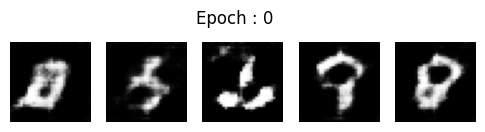

Epoch 1: Generator loss: 5.01. Discriminator loss: 0.160152
Epoch 2: Generator loss: 4.74. Discriminator loss: 0.184546
Epoch 3: Generator loss: 5.36. Discriminator loss: 0.103084
Epoch 4: Generator loss: 5.62. Discriminator loss: 0.106399
Epoch 5: Generator loss: 6.39. Discriminator loss: 0.087687


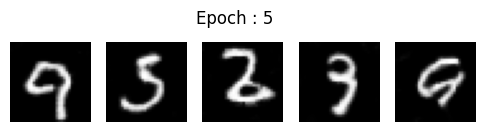

Epoch 6: Generator loss: 6.99. Discriminator loss: 0.044904
Epoch 7: Generator loss: 6.94. Discriminator loss: 0.047582
Epoch 8: Generator loss: 7.30. Discriminator loss: 0.052433
Epoch 9: Generator loss: 8.19. Discriminator loss: 0.023980
Epoch 10: Generator loss: 8.47. Discriminator loss: 0.041361


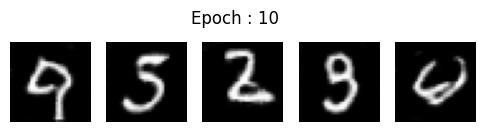

Epoch 11: Generator loss: 7.88. Discriminator loss: 0.028242
Epoch 12: Generator loss: 9.30. Discriminator loss: 0.003306
Epoch 13: Generator loss: 8.23. Discriminator loss: 0.034694
Epoch 14: Generator loss: 8.20. Discriminator loss: 0.045524
Epoch 15: Generator loss: 7.41. Discriminator loss: 0.051548


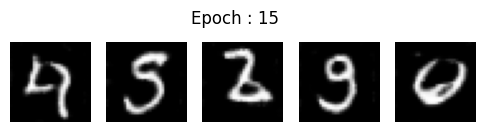

Epoch 16: Generator loss: 8.48. Discriminator loss: 0.013296
Epoch 17: Generator loss: 8.42. Discriminator loss: 0.037855
Epoch 18: Generator loss: 8.56. Discriminator loss: 0.019294
Epoch 19: Generator loss: 8.53. Discriminator loss: 0.030033
Your trained model is saved successfully!


In [28]:
generator = Generator(noise_size).to(device)
discriminator = Discriminator().to(device)

if not skip_training:
    criterion, g_optimizer, d_optimizer = loss_and_optimizer(generator, discriminator)
    gen_losses, disc_losses = train_gan(generator, discriminator, g_optimizer, d_optimizer, train_loader, noise_size, criterion, device, max_epochs=max_epochs, verbose=True)
    torch.save(generator.state_dict(), 'best_generator.pth')
    torch.save(discriminator.state_dict(), 'best_discriminator.pth')
    print("Your trained model is saved successfully!")
else:
    generator.load_state_dict(torch.load('best_generator.pth', map_location=device))
    discriminator.load_state_dict(torch.load('best_discriminator.pth', map_location=device))

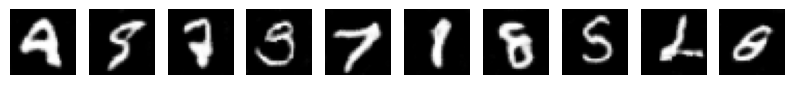

In [29]:
test_img = torch.randn(64, 100, 1, 1).to(device)
sample_gen_imgs_in_train = generator(test_img).detach().cpu().squeeze()
nrow, ncols = 1, 10
fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(10,1.5))
for ncol in range(ncols):
    axes[ncol].imshow(sample_gen_imgs_in_train[ncol], cmap='gray')
    axes[ncol].axis('off')
plt.show()